In [1]:
import numpy as np
import time
import pandas as pd
from scipy.sparse import csr_matrix
from netreco import Reconstructor, ss_sim
from netreco.Reconstructor import Profile
import matplotlib.pyplot as plt

R = 100

In [2]:
%matplotlib inline
A = [
    [0.75, 0, 0, 0, 0, 1.2],
    [-.1, -.35, 0, 0, 0, 0],
    [0, 0, .85, -1, 0, 0],
    [0, -.73, 0, .95, 0, 0],
    [0, 0, .43, 0, -.6, 0],
    [0, 0, 0, 0, .2, .55]

]
A = np.array(A)
B = [
    [1.4, 0, 0],
    [0, -.25, 0],
    [0, 0, 0.75],
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, 0]
]
B = np.array(B)
C = [
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0]
]
C = np.array(C)

# u = pd.read_csv('../scripts/u.csv', header=None).values
Pbool = np.identity(3)

real_params = {
    (1, 2): [0, 0.5],
    (1, 3): [.51, .75, -.11, -.6, -.816, .55],
    (2, 1): [.286, -.35],
    (2, 3): [0, 0.5],
    (3, 1): [0, 0.5],
    (3, 2): [7.684, .95, -8.588, .85]
}

In [3]:
def run(r, robust, u, y, plot=False):
    recon = Reconstructor(debug=plot, r=r, Pbool=Pbool, bounds=20, order=4, real_params=real_params, robust=robust)    
    
    bogus = np.zeros(R)
    # yt = y[:r, :]
    # ut = u[:r, :]
    
    params = recon.measured(y, u, plot=plot, titles=[])    
    
    ijs = [(1,2), (1,3), (2,1), (2,3), (3,1), (3,2)]
    
    err = 0
    for ij in ijs:
        i = ij[0] 
        j = ij[1] 
    
        fitparams = params[i - 1][j - 1]
    
        err_bogus, real = recon._fiterr(real_params[ij], bogus, True)
        ij_err, rcst = recon._fiterr(fitparams, real, True)    
        
        err += ij_err
        
    err = err / float(len(ijs))        
    
    if plot:
        plt.show()
        
    # if plot:
    #     plt.figure()
    #     plt.plot(range(len(real)), real, label='Actual Parameters')
    #     plt.plot(range(len(rcst)), rcst, label='Reconstructed Parameters')
    #     plt.legend()
    #     plt.show()
        
    return err

In [4]:
%matplotlib inline
from multiprocessing import Pool
from functools import partial

rs = {}
step = 0.1
rng = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# rng = [1, 2, 10, 100] 
reps = 20

def inner(rep, r):    
    np.random.seed()  # Make sure each process has a different seed
    print('Running {} - {}'.format(r, rep + 1))
    
    u = np.random.rand(601, 3) * 2 - 1
    y = ss_sim(A, B, C, u)
        
    van = run(r, False, u, y, plot=False)
    # rob = run(r, True, u, y, plot=False)
    
    rs = {
        'Vanilla': van,
        # 'Robust': rob
    }
    
    print('\tDone {} - {}. Vanilla = {:.3f}'.format(r, rep + 1, van))
    return rs

for r in rng:
    f = partial(inner, r=r)
    
    p = Pool(reps)
    rss = p.map(f, range(reps))
    
    # rss = map(f, range(reps))
    
    rs[r] = {
        'Vanilla': sum([item['Vanilla'] for item in rss]) / float(reps),
        # 'Robust': sum([item['Robust'] for item in rss]) / float(reps)
    }  

Running 1 - 1
Running 1 - 10
Running 1 - 11
Running 1 - 9
Running 1 - 18
Running 1 - 15
Running 1 - 19
Running 1 - 13
Running 1 - 20
Running 1 - 12
Running 1 - 17
Running 1 - 14
Running 1 - 16
Running 1 - 2
Running 1 - 3
Running 1 - 6
Running 1 - 5
Running 1 - 7
Running 1 - 4
Running 1 - 8
	Done 1 - 20. Vanilla = 0.547
	Done 1 - 16. Vanilla = 0.819
	Done 1 - 12. Vanilla = 0.656
	Done 1 - 11. Vanilla = 0.636
	Done 1 - 15. Vanilla = 0.610
	Done 1 - 14. Vanilla = 0.969
	Done 1 - 18. Vanilla = 0.568
	Done 1 - 7. Vanilla = 0.853
	Done 1 - 17. Vanilla = 0.537
	Done 1 - 10. Vanilla = 1.515
	Done 1 - 13. Vanilla = 0.879
	Done 1 - 1. Vanilla = 0.590
	Done 1 - 5. Vanilla = 1.086
	Done 1 - 8. Vanilla = 0.582
	Done 1 - 6. Vanilla = 0.585
	Done 1 - 3. Vanilla = 0.623
	Done 1 - 9. Vanilla = 0.771
	Done 1 - 2. Vanilla = 0.636
	Done 1 - 4. Vanilla = 3.043
	Done 1 - 19. Vanilla = 0.410
Running 2 - 2
Running 2 - 3
Running 2 - 1
Running 2 - 7
Running 2 - 4
Running 2 - 8
Running 2 - 10
Running 2 - 9
Runni

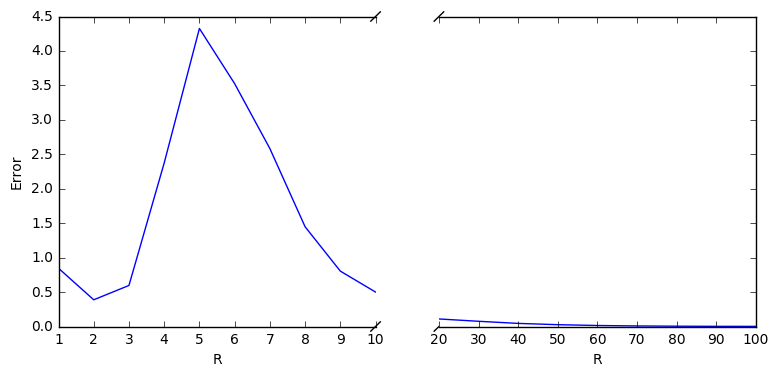

In [5]:
df = pd.DataFrame(rs).transpose()
# print(df)

f, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize=(9, 4))
ax.plot(df.axes[0], df['Vanilla'], color='b')
# ax.plot(df.axes[0], df['Robust'], color='r', linestyle='--')
ax2.plot(df.axes[0], df['Vanilla'], color='b')
# ax2.plot(df.axes[0], df['Robust'], color='r', linestyle='--', label='Robust')

ax.set_xlim(1,10)
ax2.set_xlim(20,100)

ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax.yaxis.tick_left()
ax2.yaxis.tick_right()
ax2.tick_params(labelright='off')

d = 0.015
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # Bottom-left diagonal
ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # Top-left diagonal

kwargs.update(transform=ax2.transAxes)
ax.plot((-d, d), (-d, +d), **kwargs)  # Bottom-right diagonal
ax.plot((-d, d), (1 - d, 1 + d), **kwargs)  # Top-right diagonal

ax.set_ylabel('Error')
ax.set_xlabel('R')
ax2.set_xlabel('R')

# plt.legend()

In [6]:
run(100, plot=True)

TypeError: run() missing 3 required positional arguments: 'robust', 'u', and 'y'

In [ ]:
run(.05, plot=True)